In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

folder_path = "/content/drive/My Drive/DL-Project"
os.chdir(folder_path)

Mounted at /content/drive


# Importing Necessary Libraries

In [2]:
import numpy as np
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Loading the Data

11490434/11490434 [==============================] - 0s 0us/step


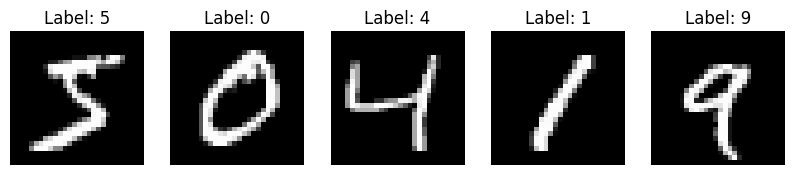

In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Display sample images
num_samples = 5

plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

# Splitting Data into Train/Cross-Validation/Test sets

In [4]:
validation_split = 0.2
num_train_samples = int(len(X_train) * (1 - validation_split))
X_train, X_val = X_train[:num_train_samples], X_train[num_train_samples:]
y_train, y_val = y_train[:num_train_samples], y_train[num_train_samples:]

print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 48000
Number of validation samples: 12000
Number of test samples: 10000


In [5]:
# We must apply one-hot encoding in order to be compitable with softmax output
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_val_one_hot = to_categorical(y_val, num_classes=10)
y_test_one_hot = to_categorical(y_test,num_classes=10)

# Installing Keras-Tuner

In [6]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.9 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
from keras_tuner import Hyperband
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from keras_tuner.engine.hyperparameters import HyperParameters

In [ ]:
hp = HyperParameters()
hp.Choice('learning_rate', values=[0.1, 0.01, 0.001])
hp.Choice('batch_size', values=[32, 128])
hp.Choice('num_conv_layers', values=[1, 2])
hp.Choice('filters', values=[16, 32])

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.get('filters'), kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for _ in range(hp.get('num_conv_layers') - 1):
        model.add(Conv2D(filters=hp.get('filters'), kernel_size=(3, 3), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=10, activation = 'softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=hp.get('learning_rate')),
        loss='mean_squared_error',
        metrics=['accuracy']
    )

    return model

In [ ]:
# hyperparameter search
tuner = Hyperband(build_model, hyperparameters=hp, objective='val_accuracy', max_epochs=10, project_name="CONV_TUNING_SGD")
tuner.search(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=hp.get('batch_size'))

Trial 30 Complete [00h 06m 23s]
val_accuracy: 0.10599999874830246

Best val_accuracy So Far: 0.9742500185966492
Total elapsed time: 01h 26m 09s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
# Print the selected hyperparameter values
print("Selected Learning Rate:", best_hp.get('learning_rate'))
print("Selected Batch Size:", best_hp.get('batch_size'))
print("Selected Conv Layers:", best_hp.get('num_conv_layers'))
print("Selected Number of filters:", best_hp.get('filters'))

Selected Learning Rate: 0.01
Selected Batch Size: 32
Selected Conv Layers: 2
Selected Number of filters: 32


# MISC Functions Needed Along the Notebook

In [9]:
def define_cnn_model(num_filters: list, activation: str = 'relu', optimizer: str = 'adam', alpha: float = 0.1):
    model = Sequential()
    for i in range(len(num_filters)):
      if i == 0:
        model.add(Conv2D(filters=num_filters[i], kernel_size = (3, 3), input_shape = (28,28,1), activation = activation, padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
      else:
        model.add(Conv2D(filters=num_filters[i], kernel_size = (3,3), activation = activation, padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=10, activation = 'softmax'))

    if optimizer == 'sgd':
      model.compile(
          loss='mean_squared_error',
          optimizer=tf.keras.optimizers.SGD(learning_rate=alpha),
          metrics=['accuracy']
      )
    else:
      model.compile(
          loss='mean_squared_error',
          optimizer=tf.keras.optimizers.Adam(),
          metrics=['accuracy']
      )
    print(model.summary())
    return model

In [10]:
def create_plot(history, plotname):
  # Extract loss values from the history
  training_ac = history.history['accuracy']
  validation_ac = history.history['val_accuracy']

  # Create an array of epochs for x-axis
  epochs = np.arange(1, len(training_ac) + 1)

  # Plot training and validation losses
  plt.plot(epochs, training_ac, label='Training Accuracy')
  plt.plot(epochs, validation_ac, label='Validation Accuracy')

  # Annotate the final accuracy values on the plot
  final_training_ac = training_ac[-1]
  final_validation_ac = validation_ac[-1]

  plt.annotate(f'Final Training Acc: {final_training_ac:.3f}',
              xy=(len(epochs), final_training_ac),
              xytext=(10, 0), textcoords='offset points',
              arrowprops=dict(arrowstyle="->"))

  plt.annotate(f'Final Validation Acc: {final_validation_ac:.3f}',
              xy=(len(epochs), final_validation_ac),
              xytext=(-50, 20), textcoords='offset points',
              arrowprops=dict(arrowstyle="->"))


  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('HitRate Over Training Steps')
  plt.legend()
  # Save the plot as a PNG image
  plt.savefig(plotname)
  plt.show()
  return final_training_ac, final_validation_ac

In [11]:
def create_report(y_pred, final_training_ac, final_validation_ac):
  y_predicted = np.argmax(y_pred, axis=1)
  accuracy = np.mean(y_test == y_predicted)

  correctly_classified_test = int(accuracy*X_test.shape[0])
  missclassified_test = X_test.shape[0] - correctly_classified_test

  correctly_classified_train = int(final_training_ac*X_train.shape[0])
  missclassified_train = X_train.shape[0] - correctly_classified_train

  correctly_classified_val = int(final_validation_ac*X_val.shape[0])
  missclassified_val = X_val.shape[0] - correctly_classified_val

  print("Train Set Report")
  print("="*50)
  print(f"Accuracy: {final_training_ac*100:.2f}%")
  print(f"Correctly Classified: {correctly_classified_train}")
  print(f"Missclassified: {missclassified_train}")

  print("\n\nValidation Set Report")
  print("="*50)
  print(f"Accuracy: {final_validation_ac*100:.2f}%")
  print(f"Correctly Classified: {correctly_classified_val}")
  print(f"Missclassified: {missclassified_val}")

  print("\n\nTest Set Report")
  print("="*50)
  print(f"Accuracy: {accuracy*100:.2f}%")
  print(f"Correctly Classified: {correctly_classified_test}")
  print(f"Missclassified: {missclassified_test}")


# Exp 3.0 Two Conv Layer SGD (Best Accuracy for SGD)

In [14]:
model = define_cnn_model([32,32],'relu','sgd',0.01)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [15]:
history = model.fit(X_train, y_train_one_hot, epochs = 15, validation_data = (X_val, y_val_one_hot), batch_size=32)

Epoch 1/15
1500/1500 [==============================] - 61s 40ms/step - loss: 0.1421 - accuracy: 0.2790 - val_loss: 0.1051 - val_accuracy: 0.4617
Epoch 2/15
1500/1500 [==============================] - 60s 40ms/step - loss: 0.0831 - accuracy: 0.5672 - val_loss: 0.0495 - val_accuracy: 0.7372
Epoch 3/15
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0469 - accuracy: 0.7468 - val_loss: 0.0452 - val_accuracy: 0.7542
Epoch 4/15
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0371 - accuracy: 0.7904 - val_loss: 0.0244 - val_accuracy: 0.8563
Epoch 5/15
1500/1500 [==============================] - 60s 40ms/step - loss: 0.0222 - accuracy: 0.8673 - val_loss: 0.0084 - val_accuracy: 0.9482
Epoch 6/15
1500/1500 [==============================] - 61s 41ms/step - loss: 0.0067 - accuracy: 0.9595 - val_loss: 0.0063 - val_accuracy: 0.9615
Epoch 7/15
1500/1500 [==============================] - 61s 41ms/step - loss: 0.0054 - accuracy: 0.9674 - val_loss: 0.0049 -

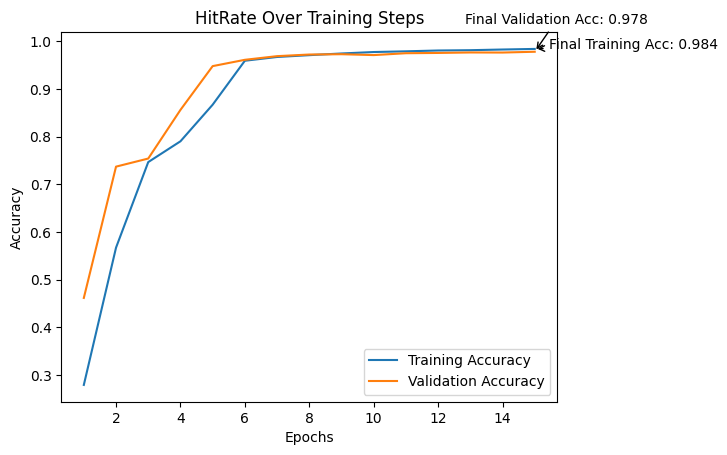

In [16]:
final_training_ac, final_validation_ac = create_plot(history, "./plots/cnn_sgd_30.png")

In [17]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 4s 12ms/step
Train Set Report
Accuracy: 98.44%
Correctly Classified: 47248
Missclassified: 752


Validation Set Report
Accuracy: 97.84%
Correctly Classified: 11741
Missclassified: 259


Test Set Report
Accuracy: 97.76%
Correctly Classified: 9776
Missclassified: 224


# Tuning HyperParameters with Adam Optimizer

In [ ]:
hp = HyperParameters()
hp.Choice('batch_size', values=[32, 128])
hp.Choice('num_conv_layers', values=[1, 2])
hp.Choice('filters', values=[16, 32, 64])

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.get('filters'), kernel_size=(3, 3), input_shape=(28, 28, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for _ in range(hp.get('num_conv_layers') - 1):
        model.add(Conv2D(filters=hp.get('filters'), kernel_size=(3, 3), padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=10, activation = 'softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='mean_squared_error',
        metrics=['accuracy']
    )

    return model

In [ ]:
# hyperparameter search
tuner = Hyperband(build_model, hyperparameters=hp, objective='val_accuracy', max_epochs=10, project_name="CONV_TUNING_ADAM")
tuner.search(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), batch_size=hp.get('batch_size'))

Trial 18 Complete [00h 02m 29s]
val_accuracy: 0.3722499907016754

Best val_accuracy So Far: 0.9781666398048401
Total elapsed time: 00h 36m 08s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
# Print the selected hyperparameter values
print("Selected Batch Size:", best_hp.get('batch_size'))
print("Selected Conv Layers:", best_hp.get('num_conv_layers'))
print("Selected Number of filters:", best_hp.get('filters'))

Selected Batch Size: 128
Selected Conv Layers: 2
Selected Number of filters: 16


# Exp 4.0: Two Layer CNN with ADAM optimizer (Less Parameters)

In [18]:
model = define_cnn_model([16,16], 'relu', 'adam', 0.001)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [20]:
history = model.fit(X_train, y_train_one_hot, epochs = 15, validation_data = (X_val, y_val_one_hot), batch_size=128)

Epoch 1/15
375/375 [==============================] - 41s 107ms/step - loss: 0.1107 - accuracy: 0.4368 - val_loss: 0.1032 - val_accuracy: 0.4758
Epoch 2/15
375/375 [==============================] - 34s 91ms/step - loss: 0.1026 - accuracy: 0.4778 - val_loss: 0.1020 - val_accuracy: 0.4808
Epoch 3/15
375/375 [==============================] - 33s 88ms/step - loss: 0.0575 - accuracy: 0.7001 - val_loss: 0.0276 - val_accuracy: 0.8542
Epoch 4/15
375/375 [==============================] - 32s 86ms/step - loss: 0.0265 - accuracy: 0.8600 - val_loss: 0.0249 - val_accuracy: 0.8670
Epoch 5/15
375/375 [==============================] - 36s 95ms/step - loss: 0.0241 - accuracy: 0.8706 - val_loss: 0.0231 - val_accuracy: 0.8747
Epoch 6/15
375/375 [==============================] - 32s 84ms/step - loss: 0.0222 - accuracy: 0.8762 - val_loss: 0.0210 - val_accuracy: 0.8777
Epoch 7/15
375/375 [==============================] - 32s 84ms/step - loss: 0.0176 - accuracy: 0.8897 - val_loss: 0.0046 - val_accuracy

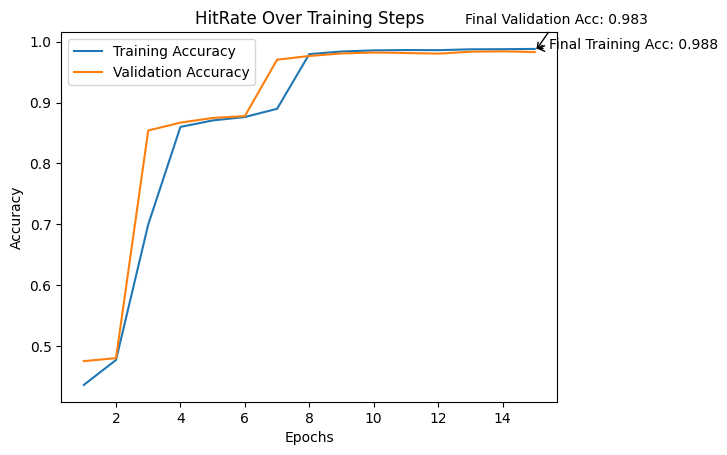

In [21]:
final_training_ac, final_validation_ac = create_plot(history, "./plots/cnn_adam_40.png")

In [22]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 3s 8ms/step
Train Set Report
Accuracy: 98.79%
Correctly Classified: 47419
Missclassified: 581


Validation Set Report
Accuracy: 98.28%
Correctly Classified: 11793
Missclassified: 207


Test Set Report
Accuracy: 98.41%
Correctly Classified: 9841
Missclassified: 159


In [23]:
pkl.dump(model, open("./models/best_cnn_model_40.pkl", 'wb'))

# Exp 4.1: Swish Activation with the same previous architecture

In [34]:
from tensorflow.keras.layers import Activation

# Define the Swish activation function
def swish(x):
    return x * tf.keras.activations.sigmoid(x)

In [35]:
# Create a Sequential model with Swish activation
model = Sequential([
    Conv2D(filters=16, kernel_size = (3, 3),input_shape=(28,28,1), padding='same'),
    Activation(swish),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size = (3, 3),padding='same'),
    Activation(swish),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=10, activation='softmax')
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 activation_6 (Activation)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 16)        2320      
                                                                 
 activation_7 (Activation)   (None, 14, 14, 16)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                 

In [36]:
history = model.fit(X_train, y_train_one_hot, epochs = 15, validation_data = (X_val, y_val_one_hot), batch_size=128)

Epoch 1/15
375/375 [==============================] - 45s 118ms/step - loss: 0.1071 - accuracy: 0.4480 - val_loss: 0.0840 - val_accuracy: 0.5633
Epoch 2/15
375/375 [==============================] - 40s 108ms/step - loss: 0.0555 - accuracy: 0.7042 - val_loss: 0.0434 - val_accuracy: 0.7648
Epoch 3/15
375/375 [==============================] - 39s 103ms/step - loss: 0.0401 - accuracy: 0.7729 - val_loss: 0.0232 - val_accuracy: 0.8546
Epoch 4/15
375/375 [==============================] - 44s 118ms/step - loss: 0.0199 - accuracy: 0.8683 - val_loss: 0.0180 - val_accuracy: 0.8730
Epoch 5/15
375/375 [==============================] - 41s 109ms/step - loss: 0.0107 - accuracy: 0.9250 - val_loss: 0.0041 - val_accuracy: 0.9742
Epoch 6/15
375/375 [==============================] - 38s 101ms/step - loss: 0.0032 - accuracy: 0.9797 - val_loss: 0.0038 - val_accuracy: 0.9762
Epoch 7/15
375/375 [==============================] - 39s 104ms/step - loss: 0.0029 - accuracy: 0.9820 - val_loss: 0.0036 - val_ac

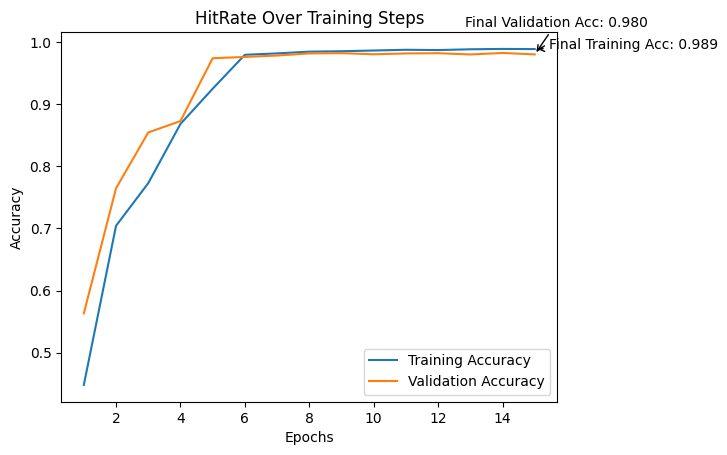

In [37]:
final_training_ac, final_validation_ac = create_plot(history, "./plots/cnn_adam_swish_41.png")

In [38]:
y_pred = model.predict(X_test)
create_report(y_pred, final_training_ac, final_validation_ac)

313/313 [==============================] - 3s 10ms/step
Train Set Report
Accuracy: 98.89%
Correctly Classified: 47467
Missclassified: 533


Validation Set Report
Accuracy: 98.03%
Correctly Classified: 11763
Missclassified: 237


Test Set Report
Accuracy: 98.10%
Correctly Classified: 9810
Missclassified: 190


In [39]:
pkl.dump(model, open("./models/best_cnn_model_41_swish.pkl", 'wb'))